<div align="left">
<img align="left" src="../misc/cinlogo.jpg" height="60" width="60" >
<div> <b> UNET </b> </div>
<div> Pedro D. Marrero Fernandez</div>
<div> :), :(, :/</div>
</div>                

In [7]:
import os
import sys
import numpy as np
import pandas as pd
import csv

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform
from skimage import color
import scipy.misc
import scipy.ndimage as ndi

from pytvision import visualization as view
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
from torchlib.segneuralnet import SegmentationNeuralNet
from torchlib.datasets.dsxbdata import DSXBExDataset, DSXBDataset, DSDataset
from torchlib.datasets import imageutl as imutl
from torchlib.transforms import functional as F
from torchlib import utils
from torchlib.metrics import intersection_over_union, intersection_over_union_thresholds
from torchlib.metrics import compute_ious

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')

from aug import get_transforms_aug, get_transforms_det, get_transforms_test


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
!ls ../out/netruns/

baseline_unetresnet34_mcedice_adam_cambiaext_0001


In [3]:
# configuration
project          = '../out/netruns'
name             = 'baseline_unetresnet34_mcedice_adam_cambiaext_0001'
pathnamedataset  = os.path.expanduser('~/.datasets/cambiaext')
pathmodel        = os.path.join( project, name, 'models/model_best.pth.tar' )  #model_best, chk000015
batch_size       = 2
workers          = 1
cuda             = False
parallel         = False
gpu              = 1
seed             = 1
imsize           = 512
num_channels     = 3
sub_folder       = 'train'

In [4]:
dataset = DSXBDataset(    
    pathnamedataset, 
    sub_folder, 
    folders_contours='touchs',
    num_channels=num_channels,
    transform=get_transforms_test( imsize ),
    )

print(len(dataset))
print(':)!!!')

10
:)!!!


In [10]:
# load model
print('>> Load model ...')

net = SegmentationNeuralNet( 
    patchproject=project, 
    nameproject=name, 
    no_cuda=cuda, 
    parallel=parallel, 
    seed=seed, 
    gpu=gpu 
    )

if net.load( pathmodel ) is not True:
    assert(False)

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


>> Load model ...
=> loading checkpoint '../out/netruns/baseline_unetresnet34_mcedice_adam_cambiaext_0001/models/model_best.pth.tar'
=> loaded checkpoint for unetresnet34 arch!


torch.Size([1, 3, 256, 256])


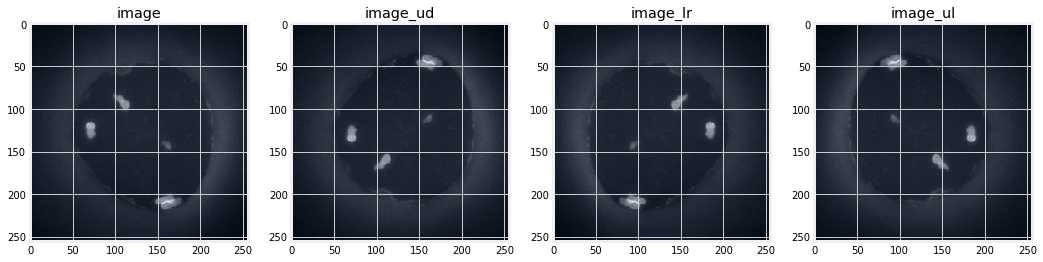

In [7]:
def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

sample   = dataset[ 0 ]
image    = sample['image'].unsqueeze(0)
print(image.shape)

image_ud = F.flipud( image )
image_lr = F.fliplr( image )
image_ul = F.flipud( F.fliplr( image ) )

image    = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_ud = image_ud.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_lr = image_lr.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_ul = image_ul.data.cpu().numpy().transpose(2,3,1,0)[...,0]


plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow( norm(image) )
plt.title('image')
plt.subplot(142)
plt.imshow( norm(image_ud) )
plt.title('image_ud')
plt.subplot(143)
plt.imshow( norm(image_lr) )
plt.title('image_lr')
plt.subplot(144)
plt.imshow( norm(image_ul) )
plt.title('image_ul')
plt.show()

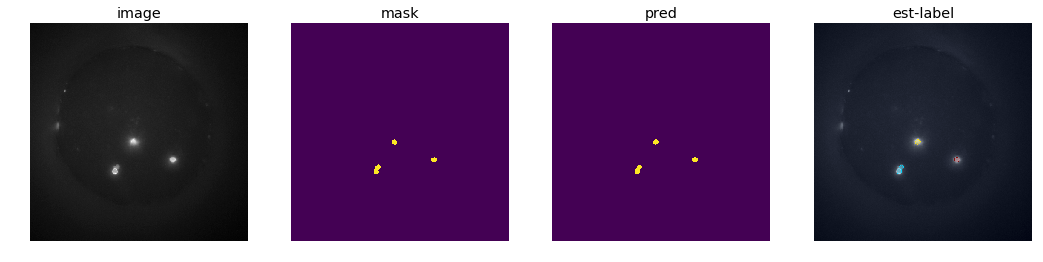

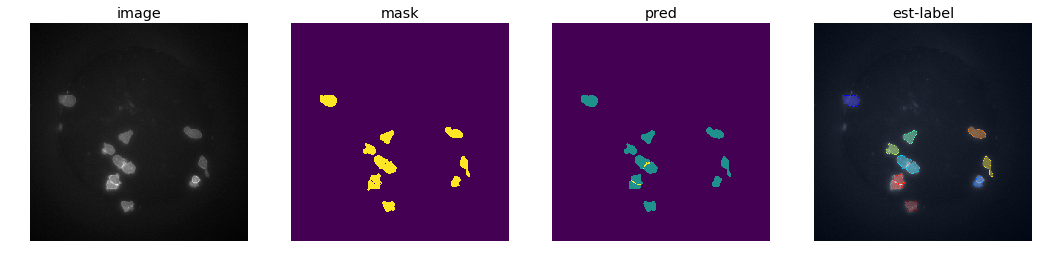

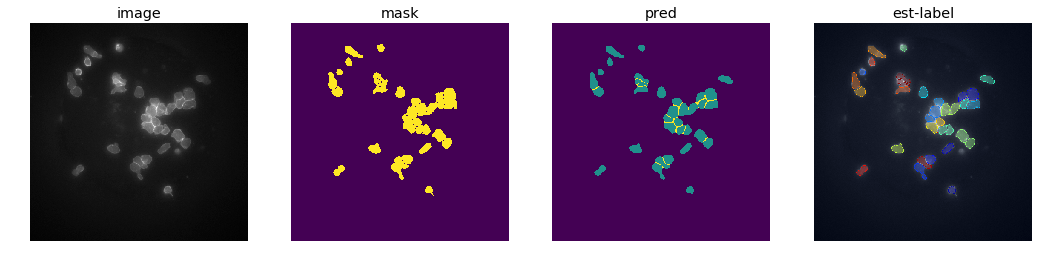

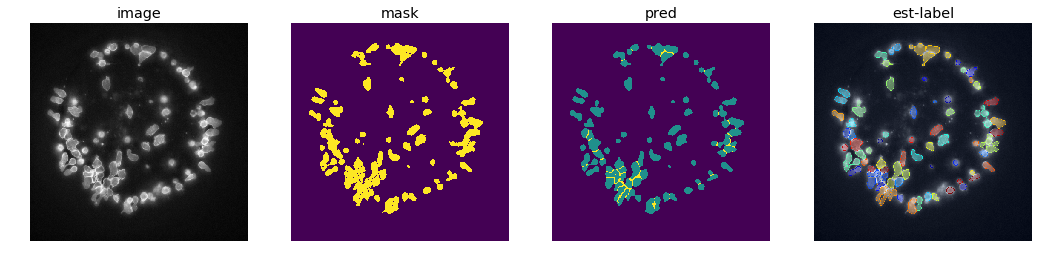

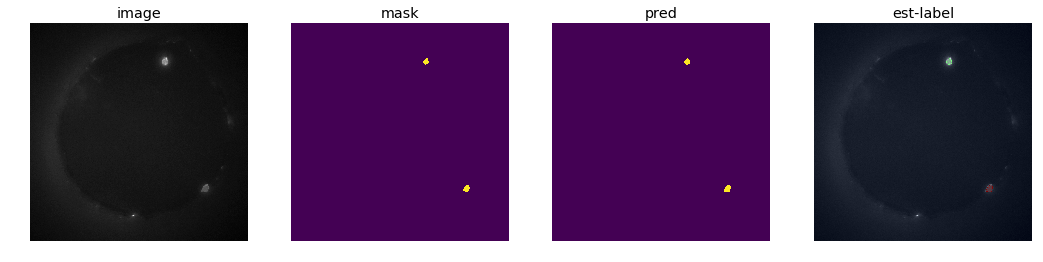

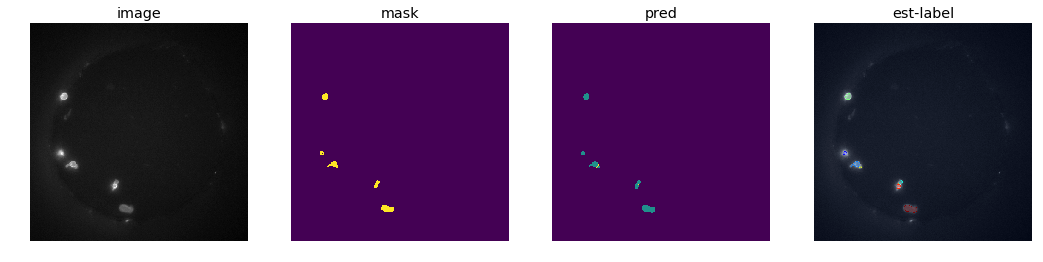

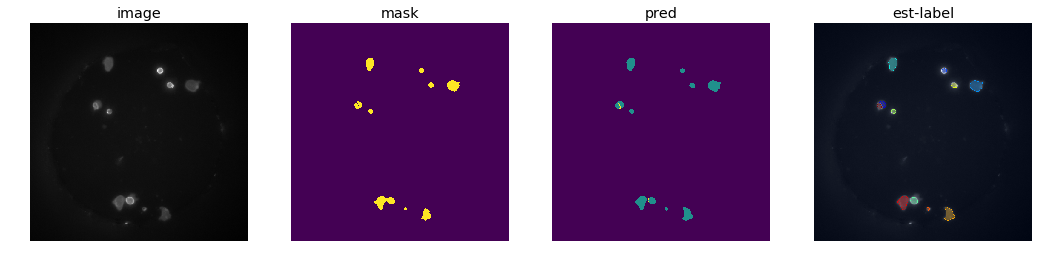

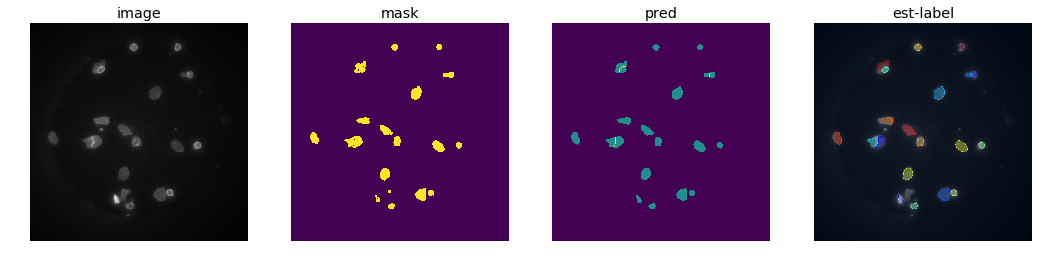

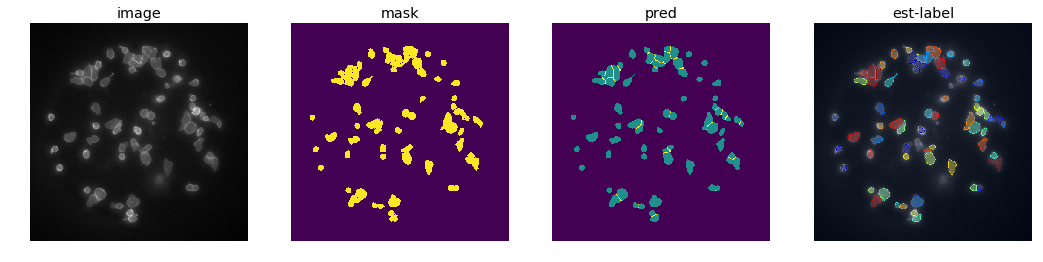

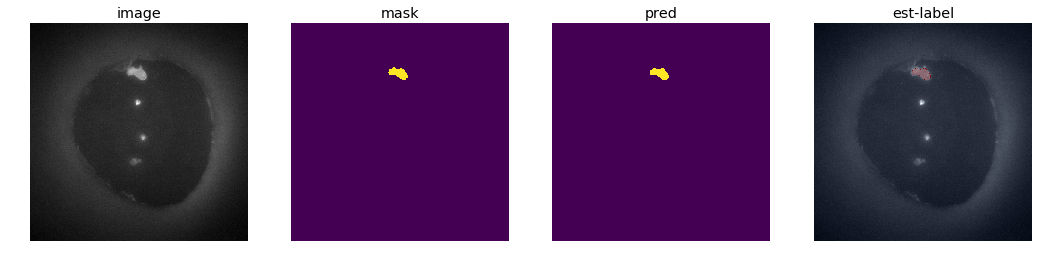

In [32]:

idx=0
k=0
for i in range( len(dataset) ):
    
    idx = i
    sample = dataset[ idx ]    
    mask = sample['label'][1,:,:].data.numpy()
    #mask = mask[92:92+116, 92:92+116]

    #idname = dataset.data.getimagename( idx )
    score = net( sample['image'].unsqueeze(0) ).float()
    score = score.data.cpu().numpy().transpose(2,3,1,0)[...,0]

    #score = F.resize_unet_inv_transform( score, (101,101,3), 101, cv2.INTER_CUBIC )
    #mask  = F.resize_unet_inv_transform( mask , (101,101,3), 101, cv2.INTER_LINEAR )

    pred  = np.argmax( score, axis=2 )
    #pred  = sigmoid( score[:,:,1] ) > 0.65 
    #print(score.shape)
        
    #if mask.sum() < 1:
    #    continue
    
    #iou = compute_ious(mask.astype(int), (pred == 1).astype(int))   
    #if iou > 0.4: continue
    #print(idx, iou)
    
    #-----
    image = sample['image'].numpy().transpose(  (1,2,0) )
    #labels_mask_est = np.transpose( pred, (1,2,0) )
    labels_mask_est = np.transpose( utils.decompose( utils.tolabel( pred == 1 ) ), (1,2,0) )    
    labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
    imagecell_est = view.makeimagecell( image, labels_mask_est, alphaback=0.3, alphaedge=0.9)
    
    
    k+=1    
    if k > 10:
        break

    plt.figure( figsize=(16,8))
    plt.subplot(141)
    plt.imshow(sample['image'][0,:,:], cmap='gray')
    plt.title('image')
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(mask)
    plt.title('mask')
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(pred)
    plt.title('pred')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow( imagecell_est  ) 
    plt.title('est-label')
    plt.axis('off')
    plt.show()




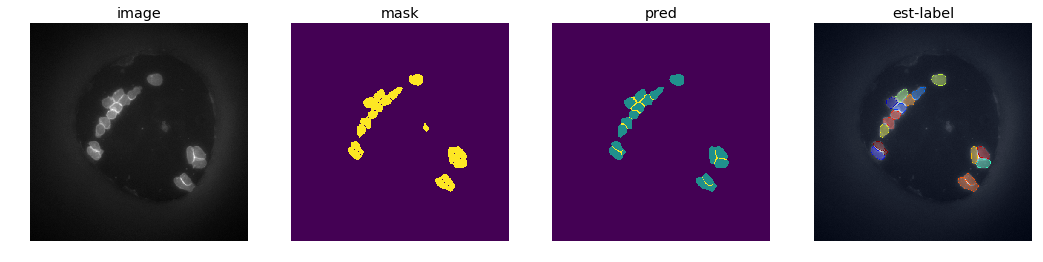

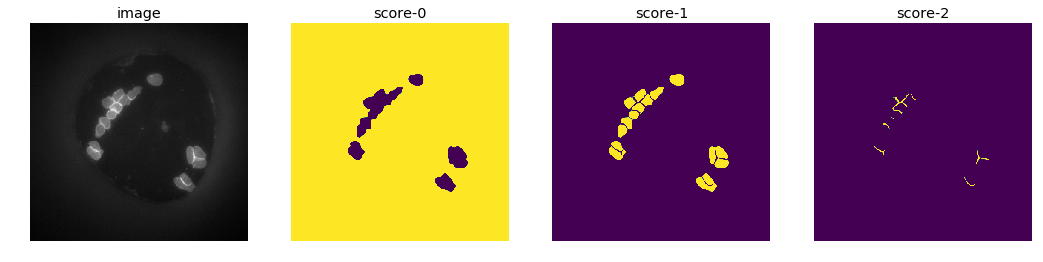

In [29]:
idx = 1
sample = dataset[ idx ]    
mask = sample['label'][1,:,:].data.numpy()

score = net( sample['image'].unsqueeze(0) ).float()
score = score.data.cpu().numpy().transpose(2,3,1,0)[...,0]

pred  = np.argmax( score, axis=2 )

#-----
image = sample['image'].numpy().transpose(  (1,2,0) )
#labels_mask_est = np.transpose( pred, (1,2,0) )
labels_mask_est = np.transpose( utils.decompose( utils.tolabel( pred == 1 ) ), (1,2,0) )    
labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell( image, labels_mask_est, alphaback=0.3, alphaedge=0.9)


plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow(sample['image'][0,:,:], cmap='gray')
plt.title('image')
plt.axis('off')
plt.subplot(142)
plt.imshow(mask)
plt.title('mask')
plt.axis('off')
plt.subplot(143)
plt.imshow(pred)
plt.title('pred')
plt.axis('off')
plt.subplot(144)
plt.imshow( imagecell_est  ) 
plt.title('est-label')
plt.axis('off')
plt.show()

plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow(sample['image'][0,:,:], cmap='gray')
plt.title('image')
plt.axis('off')
plt.subplot(142)
plt.imshow(score[:,:,0])
plt.title('score-0')
plt.axis('off')
plt.subplot(143)
plt.imshow(score[:,:,1])
plt.title('score-1')
plt.axis('off')
plt.subplot(144)
plt.imshow( score[:,:,2]  ) 
plt.title('score-2')
plt.axis('off')
plt.show()


In [19]:
pathdataset     = '~/.datasets'
namedataset     = 'cambiatwo'
folders_images  = 'images'
folders_labels  = 'labels'
sub_folder      =  ''
imsize=256

pathname = os.path.join(os.path.expanduser( pathdataset ), namedataset)
dataloader = imutl.cambiaProvide.create(
    pathname, 
    sub_folder, 
    folders_images, 
    folders_labels,
    )

dataset = DSDataset(    
    dataloader,
    num_channels=num_channels,
    transform=get_transforms_det( imsize ),
    )

print(len(dataset))
print(':)!!!')



29
:)!!!


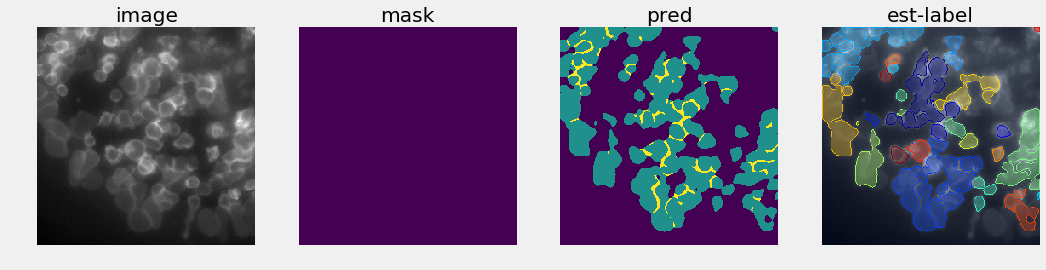

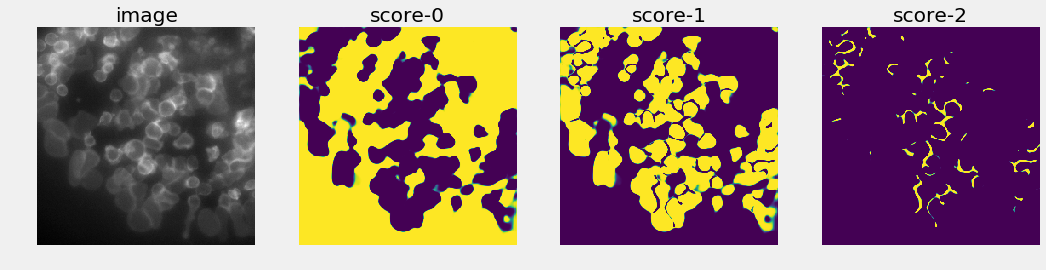

In [20]:

idx = 6
sample = dataset[ idx ]    
mask = sample['label'][1,:,:].data.numpy()

score = net( sample['image'].unsqueeze(0) ).float()
score = score.data.cpu().numpy().transpose(2,3,1,0)[...,0]

pred  = np.argmax( score, axis=2 )

#-----
image = sample['image'].numpy().transpose(  (1,2,0) )
#labels_mask_est = np.transpose( pred, (1,2,0) )
labels_mask_est = np.transpose( utils.decompose( utils.tolabel( pred == 1 ) ), (1,2,0) )    
labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell( image, labels_mask_est, alphaback=0.3, alphaedge=0.9)


plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow(sample['image'][0,:,:], cmap='gray')
plt.title('image')
plt.axis('off')
plt.subplot(142)
plt.imshow(mask)
plt.title('mask')
plt.axis('off')
plt.subplot(143)
plt.imshow(pred)
plt.title('pred')
plt.axis('off')
plt.subplot(144)
plt.imshow( imagecell_est  ) 
plt.title('est-label')
plt.axis('off')
plt.show()

plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow(sample['image'][0,:,:], cmap='gray')
plt.title('image')
plt.axis('off')
plt.subplot(142)
plt.imshow(score[:,:,0])
plt.title('score-0')
plt.axis('off')
plt.subplot(143)
plt.imshow(score[:,:,1])
plt.title('score-1')
plt.axis('off')
plt.subplot(144)
plt.imshow( score[:,:,2]  ) 
plt.title('score-2')
plt.axis('off')
plt.show()



